In [2]:
!pip install wordcloud gensim

In [3]:
import re

from gensim.models import Word2Vec

import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [17]:
# https://www.kaggle.com/datasets/arushchillar/disneyland-reviews
df = pd.read_csv('DisneylandReviews.csv', encoding="latin-1")

In [18]:
df

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
...,...,...,...,...,...,...
42651,1765031,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,Disneyland_Paris
42652,1659553,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris
42653,1645894,5,missing,South Africa,My eleven year old daughter and myself went to...,Disneyland_Paris
42654,1618637,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris


### Entender el dataset

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [20]:
# mostrar filas de 100 a 200
df.iloc[100:201, :]

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
100,662664830,3,2019-2,India,"It s a very huge game cum theme park, so if ...",Disneyland_HongKong
101,662641193,1,2019-3,India,The main attractions were shut while we still ...,Disneyland_HongKong
102,662600452,4,2019-3,Singapore,While it's not as great other Disney propertie...,Disneyland_HongKong
103,662592140,4,2019-4,United States,We made it to Honk Kong Disney on the MTR and ...,Disneyland_HongKong
104,662516931,5,2019-3,Australia,"Even though it is smaller, there is great ride...",Disneyland_HongKong
...,...,...,...,...,...,...
196,653828557,4,2018-12,Hong Kong,Such a lovely place that really took me back t...,Disneyland_HongKong
197,653746393,5,2018-3,United Arab Emirates,Fantastic experience. Enjoyed every step of ou...,Disneyland_HongKong
198,653600635,5,2018-5,Indonesia,No doubt people keep saying this is the happie...,Disneyland_HongKong
199,653600185,4,2018-6,Hong Kong,We never had went Tokyo Disneyland or Shanghai...,Disneyland_HongKong


In [21]:
## ¿Hay comentarios largos?

def calculate_words(fila):
    word = fila["Review_Text"]
    return len(word.split(" "))

df["words_count"] = df.apply(calculate_words, axis=1)

In [22]:
df.describe()

,Review_ID,Rating,words_count
count,4.265600e+04,42656.000000,42656.000000
mean,3.188553e+08,4.217695,132.174723
std,1.657092e+08,1.063371,160.717790
min,1.398724e+06,1.000000,4.000000
25%,1.743274e+08,4.000000,46.000000
50%,2.907583e+08,5.000000,82.000000
75%,4.489579e+08,5.000000,158.000000
max,6.708014e+08,5.000000,5600.000000


In [23]:
df[df["words_count"] < 5]

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,words_count
29981,606997669,5,2018-8,France,ActiveX VT ERROR:,Disneyland_Paris,4
32592,457253942,5,2016-5,Saudi Arabia,ActiveX VT ERROR:,Disneyland_Paris,4


#### Palabras que se repiten

In [24]:
texto_completo = ' '.join(review for review in df['Review_Text'])


Generando la nube de palabras...


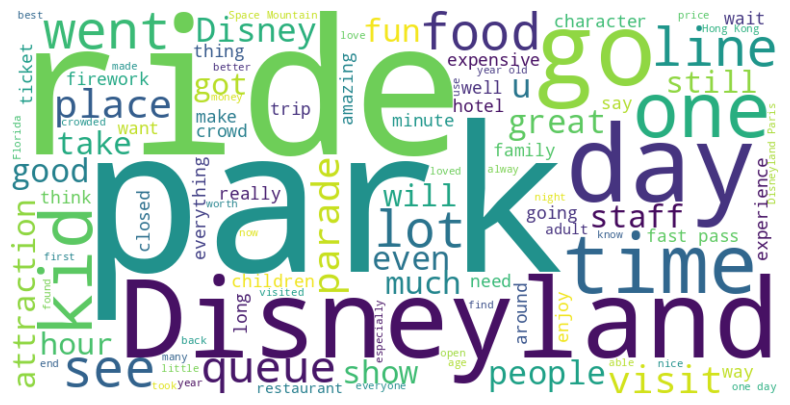

In [25]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      max_words=100,
                      width=800,
                      height=400).generate(texto_completo)

print("\nGenerando la nube de palabras...")
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Preprocesamiento

#### 0. Quitar ruido identificado

In [26]:
df["Review_Text"]

,Review_Text
0,If you've ever been to Disneyland anywhere you...
1,Its been a while since d last time we visit HK...
2,Thanks God it wasn t too hot or too humid wh...
3,HK Disneyland is a great compact park. Unfortu...
4,"the location is not in the city, took around 1..."
...,...
42651,i went to disneyland paris in july 03 and thou...
42652,2 adults and 1 child of 11 visited Disneyland ...
42653,My eleven year old daughter and myself went to...
42654,"This hotel, part of the Disneyland Paris compl..."


In [27]:
## remover espacio en "wasn   t"
df['Review_Text'] = df['Review_Text'].str.replace(r'wasn\s+t', "wasn't", regex=True)

In [28]:
df["Review_Text"]

,Review_Text
0,If you've ever been to Disneyland anywhere you...
1,Its been a while since d last time we visit HK...
2,Thanks God it wasn't too hot or too humid when...
3,HK Disneyland is a great compact park. Unfortu...
4,"the location is not in the city, took around 1..."
...,...
42651,i went to disneyland paris in july 03 and thou...
42652,2 adults and 1 child of 11 visited Disneyland ...
42653,My eleven year old daughter and myself went to...
42654,"This hotel, part of the Disneyland Paris compl..."


#### 1. Minúsculas

In [29]:
df["processed_text"] = df["Review_Text"].str.lower()

In [30]:
df["processed_text"]

,processed_text
0,if you've ever been to disneyland anywhere you...
1,its been a while since d last time we visit hk...
2,thanks god it wasn't too hot or too humid when...
3,hk disneyland is a great compact park. unfortu...
4,"the location is not in the city, took around 1..."
...,...
42651,i went to disneyland paris in july 03 and thou...
42652,2 adults and 1 child of 11 visited disneyland ...
42653,my eleven year old daughter and myself went to...
42654,"this hotel, part of the disneyland paris compl..."


#### 2. Remover caracteres especiales

In [31]:
def remove_especial_text(row):
    # Eliminar números (enteros y decimales)
    row = re.sub(r'\d+', '', row)

    # Eliminar caracteres especiales (puntuación, símbolos, etc.)
    row = re.sub(r'[^\w\s]', '', row)

    # Eliminar espacios extra y limpiar al inicio y final
    row = ' '.join(row.split())

    return row

df["processed_text"] = df["processed_text"].apply(remove_especial_text)

In [32]:
df["processed_text"]

,processed_text
0,if youve ever been to disneyland anywhere youl...
1,its been a while since d last time we visit hk...
2,thanks god it wasnt too hot or too humid when ...
3,hk disneyland is a great compact park unfortun...
4,the location is not in the city took around ho...
...,...
42651,i went to disneyland paris in july and thought...
42652,adults and child of visited disneyland paris b...
42653,my eleven year old daughter and myself went to...
42654,this hotel part of the disneyland paris comple...


In [33]:
# valores con espacios
df_espacios = df[df["processed_text"].str.replace(r'\s+', '', regex=True) == '']
df_espacios

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,words_count,processed_text


#### 3. initial tokenization

In [34]:
df["tokenization"] = df["processed_text"].str.split(" ")

In [35]:
df["tokenization"]

,tokenization
0,"[if, youve, ever, been, to, disneyland, anywhe..."
1,"[its, been, a, while, since, d, last, time, we..."
2,"[thanks, god, it, wasnt, too, hot, or, too, hu..."
3,"[hk, disneyland, is, a, great, compact, park, ..."
4,"[the, location, is, not, in, the, city, took, ..."
...,...
42651,"[i, went, to, disneyland, paris, in, july, and..."
42652,"[adults, and, child, of, visited, disneyland, ..."
42653,"[my, eleven, year, old, daughter, and, myself,..."
42654,"[this, hotel, part, of, the, disneyland, paris..."


#### 4. stop words

In [36]:
def remove_stopwords(words):
    filtered_words = [word for word in words if word not in STOPWORDS]

    return filtered_words

df['tokenization'] = df['tokenization'].apply(remove_stopwords)

In [37]:
df['tokenization'][0]

['youve',
 'disneyland',
 'anywhere',
 'youll',
 'find',
 'disneyland',
 'hong',
 'kong',
 'similar',
 'layout',
 'walk',
 'main',
 'street',
 'familiar',
 'feel',
 'one',
 'rides',
 'small',
 'world',
 'absolutely',
 'fabulous',
 'worth',
 'day',
 'visited',
 'fairly',
 'hot',
 'relatively',
 'busy',
 'queues',
 'moved',
 'fairly',
 'well']

#### 5. Revisión final

In [38]:
df_vacias = df[df['tokenization'].apply(len) == 0]

print("Filas con listas de tokens vacías:")
print(df_vacias)

Filas con listas de tokens vacías:
Empty DataFrame
Columns: [Review_ID, Rating, Year_Month, Reviewer_Location, Review_Text, Branch, words_count, processed_text, tokenization]
Index: []


#### 6. Calcular "target"

In [39]:
df["Rating"].value_counts()

,count
Rating,
5,23146
4,10775
3,5109
2,2127
1,1499


In [40]:
df["target"] = df.apply(lambda x: 1 if x["Rating"] == 5 else 0, axis = 1)
df["target"]

,target
0,0
1,0
2,0
3,0
4,0
...,...
42651,1
42652,1
42653,1
42654,0


### Modelo 1 - TFIDF + Regresión Logistica (Propia)

In [41]:
# Crear objeto de tf-idf
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=100
)
X  = vectorizer.fit_transform(df['processed_text'])

In [42]:
vectorizer.get_feature_names_out().shape

(100,)

In [43]:
vectorizer.get_feature_names_out()[0:1000]

array(['amazing', 'attractions', 'best', 'better', 'big', 'bit', 'busy',
       'california', 'characters', 'children', 'closed', 'come',
       'crowded', 'day', 'days', 'did', 'didnt', 'disney', 'disneyland',
       'dont', 'early', 'enjoy', 'enjoyed', 'expensive', 'experience',
       'family', 'fast', 'fireworks', 'food', 'fun', 'going', 'good',
       'got', 'great', 'hotel', 'hour', 'hours', 'just', 'kids', 'like',
       'line', 'lines', 'little', 'long', 'lot', 'lots', 'love', 'loved',
       'magic', 'magical', 'main', 'make', 'minutes', 'money', 'mountain',
       'need', 'new', 'nice', 'night', 'old', 'parade', 'paris', 'park',
       'parks', 'pass', 'people', 'place', 'pm', 'queue', 'queues',
       'really', 'recommend', 'ride', 'rides', 'say', 'shows', 'small',
       'space', 'staff', 'sure', 'things', 'think', 'ticket', 'tickets',
       'time', 'times', 'took', 'trip', 'use', 'visit', 'visited', 'wait',
       'waiting', 'want', 'way', 'went', 'world', 'worth', 'year'

In [ ]:

class LogisticRegressionFromScratch:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr  # tasa de aprendizaje
        self.n_iters = n_iters
        self.theta = None  # pesos

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Añadimos una columna de 1s para el término bias
        X = np.insert(X, 0, 1, axis=1)

        n_samples, n_features = X.shape
        self.theta = np.zeros(n_features)

        # Descenso por gradiente
        for _ in range(self.n_iters):
            z = np.dot(X, self.theta)
            h = self._sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / n_samples
            self.theta -= self.lr * gradient

    def predict_proba(self, X):
        X = np.insert(X, 0, 1, axis=1)
        return self._sigmoid(np.dot(X, self.theta))

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

In [ ]:
y = df["target"].values

In [ ]:
X_model = np.array(X.toarray())
X_model

array([[0.        , 0.        , 0.        , ..., 0.31276099, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.17899123, 0.35005446, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.22259941,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# Crear y entrenar el modelo
model = LogisticRegressionFromScratch(lr=0.1, n_iters=1000)
model.fit(X_model, y)


In [ ]:
#### Predecir
predicciones = model.predict(X_model)
print("Predicciones:", predicciones)

Predicciones: [1 1 0 ... 1 1 1]


### Modelo 2 - Regresión logistica + Embedding (Word2vec)

In [56]:
df['tokenization']

,tokenization
0,"[youve, disneyland, anywhere, youll, find, dis..."
1,"[d, last, time, visit, hk, disneyland, yet, ti..."
2,"[thanks, god, wasnt, hot, humid, visiting, par..."
3,"[hk, disneyland, great, compact, park, unfortu..."
4,"[location, city, took, around, hour, kowlon, k..."
...,...
42651,"[went, disneyland, paris, july, thought, brill..."
42652,"[adults, child, visited, disneyland, paris, be..."
42653,"[eleven, year, old, daughter, went, visit, son..."
42654,"[hotel, part, disneyland, paris, complex, wond..."


In [54]:
# Crear embedding
corpus = df['tokenization']
model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4)

In [59]:
## entender palabras similares

model.wv.most_similar("resort")

[('property', 0.8349226117134094),
 ('hotels', 0.7853190898895264),
 ('site', 0.7636844515800476),
 ('resorts', 0.754508376121521),
 ('anaheim', 0.6935858130455017),
 ('properties', 0.6799569129943848),
 ('proximity', 0.6627428531646729),
 ('motels', 0.6619939804077148),
 ('transportation', 0.6476344466209412),
 ('location', 0.6440061330795288)]

In [60]:
## crear representación del vector

def sentence_to_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)


X_model2 = [sentence_to_vector(sentence, model) for sentence in corpus]
y_model2 = df["target"].values

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X_model2,
    y_model2,
    test_size=0.2,
    random_state=42
)

In [62]:
# Train Logistic Regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [63]:
# Predictions and evaluation
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7378105954055321
